# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

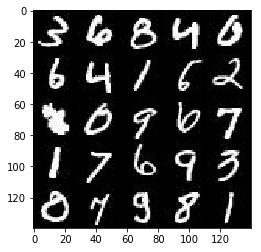

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

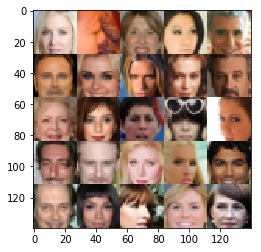

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        #Implementing leaky relu
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha=0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    steps = 0
    
    data_size, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                #Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                #Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4173... Generator Loss: 1.2634
Epoch 1/2... Discriminator Loss: 0.0617... Generator Loss: 4.8218
Epoch 1/2... Discriminator Loss: 0.0870... Generator Loss: 8.2825
Epoch 1/2... Discriminator Loss: 2.4098... Generator Loss: 0.1328
Epoch 1/2... Discriminator Loss: 0.4980... Generator Loss: 1.9710
Epoch 1/2... Discriminator Loss: 0.5838... Generator Loss: 1.0469
Epoch 1/2... Discriminator Loss: 0.3504... Generator Loss: 4.4636
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 4.9962
Epoch 1/2... Discriminator Loss: 0.1707... Generator Loss: 4.1004
Epoch 1/2... Discriminator Loss: 0.2274... Generator Loss: 2.5435


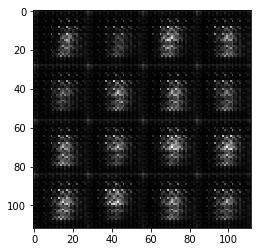

Epoch 1/2... Discriminator Loss: 0.1489... Generator Loss: 2.6930
Epoch 1/2... Discriminator Loss: 0.2774... Generator Loss: 2.8127
Epoch 1/2... Discriminator Loss: 0.2618... Generator Loss: 2.4571
Epoch 1/2... Discriminator Loss: 0.5928... Generator Loss: 1.8630
Epoch 1/2... Discriminator Loss: 0.3414... Generator Loss: 2.9133
Epoch 1/2... Discriminator Loss: 0.3139... Generator Loss: 2.2996
Epoch 1/2... Discriminator Loss: 0.4614... Generator Loss: 2.7989
Epoch 1/2... Discriminator Loss: 0.6254... Generator Loss: 3.4934
Epoch 1/2... Discriminator Loss: 0.4805... Generator Loss: 1.8367
Epoch 1/2... Discriminator Loss: 0.1791... Generator Loss: 2.7431


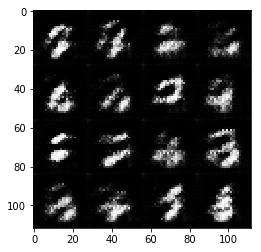

Epoch 1/2... Discriminator Loss: 0.7212... Generator Loss: 1.0715
Epoch 1/2... Discriminator Loss: 0.7762... Generator Loss: 2.8071
Epoch 1/2... Discriminator Loss: 0.5925... Generator Loss: 2.2714
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 1.2991
Epoch 1/2... Discriminator Loss: 0.7892... Generator Loss: 1.0360
Epoch 1/2... Discriminator Loss: 0.7355... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 0.7524... Generator Loss: 1.2843
Epoch 1/2... Discriminator Loss: 0.5125... Generator Loss: 1.6840
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 2.8563
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 1.0437


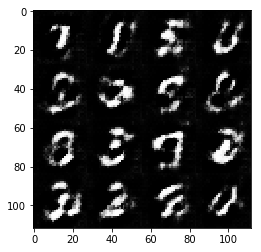

Epoch 1/2... Discriminator Loss: 0.7861... Generator Loss: 1.5439
Epoch 1/2... Discriminator Loss: 1.1441... Generator Loss: 2.1922
Epoch 1/2... Discriminator Loss: 0.8394... Generator Loss: 1.1539
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 0.9885
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.4114
Epoch 1/2... Discriminator Loss: 0.8283... Generator Loss: 0.9825
Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 1.1736
Epoch 1/2... Discriminator Loss: 0.8330... Generator Loss: 1.9422
Epoch 1/2... Discriminator Loss: 0.8327... Generator Loss: 2.3901
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 0.9133


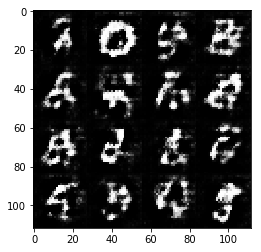

Epoch 1/2... Discriminator Loss: 1.0037... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 0.8339... Generator Loss: 0.8758
Epoch 1/2... Discriminator Loss: 0.7100... Generator Loss: 1.2831
Epoch 1/2... Discriminator Loss: 0.8305... Generator Loss: 1.2954
Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 2.4066
Epoch 1/2... Discriminator Loss: 0.6505... Generator Loss: 1.5793
Epoch 2/2... Discriminator Loss: 0.6355... Generator Loss: 1.2113
Epoch 2/2... Discriminator Loss: 0.7616... Generator Loss: 2.3520
Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 1.0282
Epoch 2/2... Discriminator Loss: 0.7502... Generator Loss: 1.1051


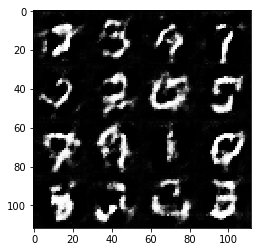

Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 0.9385
Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 0.4714
Epoch 2/2... Discriminator Loss: 0.7160... Generator Loss: 1.3200
Epoch 2/2... Discriminator Loss: 1.1119... Generator Loss: 0.5578
Epoch 2/2... Discriminator Loss: 0.8085... Generator Loss: 1.8818
Epoch 2/2... Discriminator Loss: 0.9319... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 1.1387
Epoch 2/2... Discriminator Loss: 0.8409... Generator Loss: 1.2128
Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 0.6264
Epoch 2/2... Discriminator Loss: 0.9342... Generator Loss: 0.8252


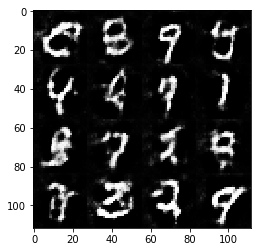

Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 0.9493
Epoch 2/2... Discriminator Loss: 0.8677... Generator Loss: 1.8599
Epoch 2/2... Discriminator Loss: 0.9296... Generator Loss: 0.8512
Epoch 2/2... Discriminator Loss: 0.9156... Generator Loss: 1.2246
Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 0.8900
Epoch 2/2... Discriminator Loss: 0.8120... Generator Loss: 1.0448
Epoch 2/2... Discriminator Loss: 0.8376... Generator Loss: 1.2761
Epoch 2/2... Discriminator Loss: 0.7554... Generator Loss: 1.1555
Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 1.3979
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 0.7635


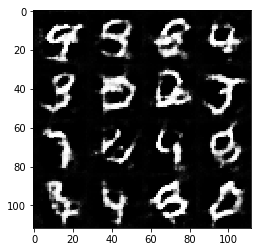

Epoch 2/2... Discriminator Loss: 0.7114... Generator Loss: 1.3392
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 1.0228
Epoch 2/2... Discriminator Loss: 1.1975... Generator Loss: 0.4783
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 2.0416
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 2.2121
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 2.0244
Epoch 2/2... Discriminator Loss: 0.8272... Generator Loss: 1.6494
Epoch 2/2... Discriminator Loss: 0.7946... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.4768
Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 2.5355


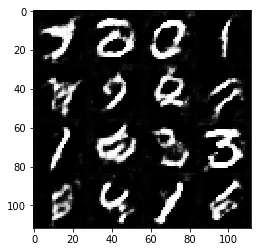

Epoch 2/2... Discriminator Loss: 0.7594... Generator Loss: 1.6241
Epoch 2/2... Discriminator Loss: 0.8273... Generator Loss: 1.6024
Epoch 2/2... Discriminator Loss: 0.8317... Generator Loss: 0.8859
Epoch 2/2... Discriminator Loss: 0.7561... Generator Loss: 1.4641
Epoch 2/2... Discriminator Loss: 0.9920... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 0.7390... Generator Loss: 1.1615
Epoch 2/2... Discriminator Loss: 0.7202... Generator Loss: 1.0953
Epoch 2/2... Discriminator Loss: 0.8530... Generator Loss: 0.7631
Epoch 2/2... Discriminator Loss: 0.7299... Generator Loss: 0.9536
Epoch 2/2... Discriminator Loss: 0.6432... Generator Loss: 1.4393


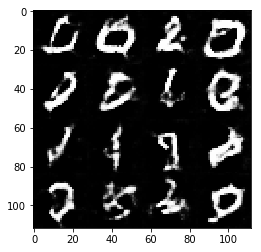

Epoch 2/2... Discriminator Loss: 2.0632... Generator Loss: 3.1330
Epoch 2/2... Discriminator Loss: 0.7047... Generator Loss: 1.1659
Epoch 2/2... Discriminator Loss: 0.6188... Generator Loss: 1.3057


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 0.3910... Generator Loss: 1.6613
Epoch 1/1... Discriminator Loss: 0.3033... Generator Loss: 5.3481
Epoch 1/1... Discriminator Loss: 3.8911... Generator Loss: 0.0237
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 9.7886
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 5.9040
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 7.5196
Epoch 1/1... Discriminator Loss: 2.7669... Generator Loss: 0.1091
Epoch 1/1... Discriminator Loss: 0.4068... Generator Loss: 4.2427


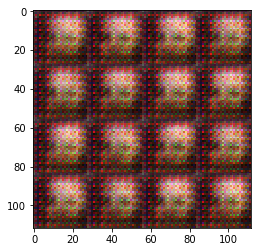

Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 2.1304
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 1.8280
Epoch 1/1... Discriminator Loss: 0.1896... Generator Loss: 2.5575
Epoch 1/1... Discriminator Loss: 0.2194... Generator Loss: 2.4959
Epoch 1/1... Discriminator Loss: 0.2706... Generator Loss: 2.6668
Epoch 1/1... Discriminator Loss: 0.1987... Generator Loss: 2.3602
Epoch 1/1... Discriminator Loss: 0.2249... Generator Loss: 2.2977
Epoch 1/1... Discriminator Loss: 0.2138... Generator Loss: 2.7695
Epoch 1/1... Discriminator Loss: 0.1112... Generator Loss: 3.1134
Epoch 1/1... Discriminator Loss: 0.2552... Generator Loss: 2.2498


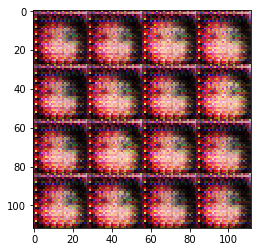

Epoch 1/1... Discriminator Loss: 0.2493... Generator Loss: 2.3445
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 1.8407
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 1.2201
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 1.7620
Epoch 1/1... Discriminator Loss: 0.2272... Generator Loss: 2.7012
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 1.8831
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 3.2193
Epoch 1/1... Discriminator Loss: 0.3071... Generator Loss: 2.3785
Epoch 1/1... Discriminator Loss: 0.3205... Generator Loss: 2.7169


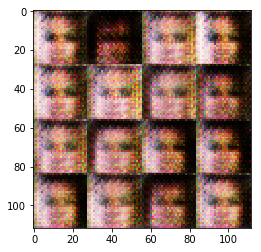

Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 2.8476
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 1.7646
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 1.3318
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.7020
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 2.1214
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.7071
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.4710
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 0.8291


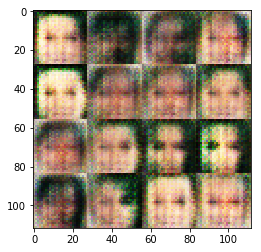

Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.8080
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 2.7716
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.5907
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 1.5964
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 1.6202


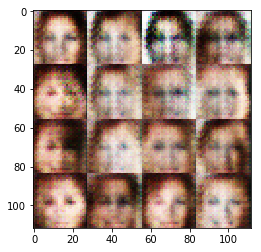

Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.4236
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.7140
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 1.7996
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 1.5971


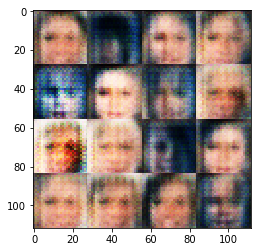

Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 2.4759
Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 2.2337
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.7874
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.6379
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 1.4425


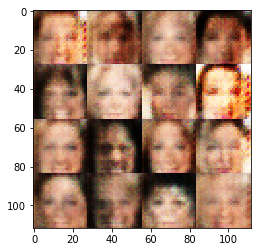

Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 1.6270
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 1.5205
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.2906
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.7780
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 2.2730
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.7075... Generator Loss: 0.3736


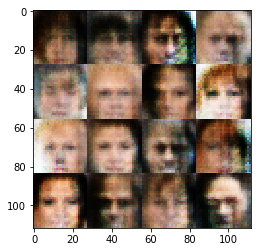

Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.4051
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 2.8060
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 2.3150
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 2.2150
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 2.2685
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.6677


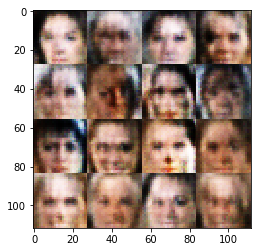

Epoch 1/1... Discriminator Loss: 1.8865... Generator Loss: 0.2680
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 1.4305
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.6845
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 1.8773
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.4167
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 3.7972


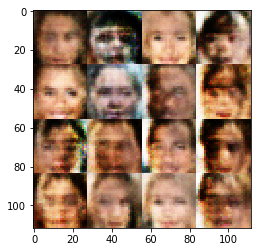

Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 2.2233
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 2.1004
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.3827
Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 2.3383
Epoch 1/1... Discriminator Loss: 0.5698... Generator Loss: 1.5541
Epoch 1/1... Discriminator Loss: 0.6643... Generator Loss: 3.5563
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.3766
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 2.2935
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.3189


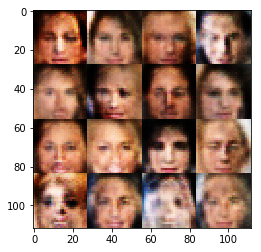

Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 2.4725
Epoch 1/1... Discriminator Loss: 0.4200... Generator Loss: 3.2507
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 3.0771
Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 1.3880
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 4.6086
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 1.6845
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 3.5716


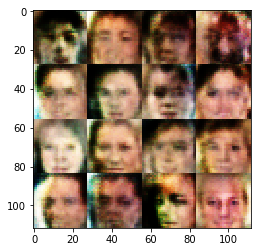

Epoch 1/1... Discriminator Loss: 0.5158... Generator Loss: 1.9583
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 2.1172
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 0.3299... Generator Loss: 1.7724
Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 2.2198
Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 4.7322
Epoch 1/1... Discriminator Loss: 0.2348... Generator Loss: 5.8542
Epoch 1/1... Discriminator Loss: 0.2575... Generator Loss: 3.0025
Epoch 1/1... Discriminator Loss: 0.6645... Generator Loss: 3.3793
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 2.8123


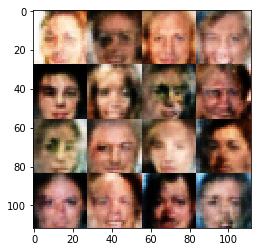

Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 0.5622... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.2886
Epoch 1/1... Discriminator Loss: 0.6257... Generator Loss: 1.0063
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 4.2873
Epoch 1/1... Discriminator Loss: 0.2843... Generator Loss: 2.7655
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 0.2136... Generator Loss: 4.7563
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 2.1746
Epoch 1/1... Discriminator Loss: 0.3406... Generator Loss: 1.5276


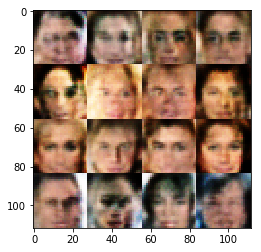

Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 0.2074... Generator Loss: 2.5025
Epoch 1/1... Discriminator Loss: 0.2026... Generator Loss: 3.2616
Epoch 1/1... Discriminator Loss: 0.6608... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 2.7713
Epoch 1/1... Discriminator Loss: 0.3704... Generator Loss: 1.6819
Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 1.3337
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 1.1704
Epoch 1/1... Discriminator Loss: 0.3420... Generator Loss: 4.3096
Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 1.3442


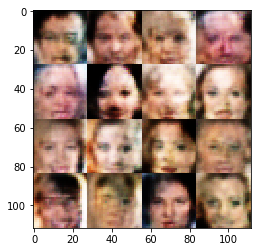

Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 4.9963
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 0.4518... Generator Loss: 1.3264
Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 4.4186
Epoch 1/1... Discriminator Loss: 0.1680... Generator Loss: 3.8583
Epoch 1/1... Discriminator Loss: 0.3154... Generator Loss: 4.1493
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 0.1143... Generator Loss: 4.6498


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.